# Assessment 2 
During the covid pandemic, governments tried to predict the levels of infection so that they could manage the required infrastructure, especially hospital beds and (sadly) mortuary places. In this mini-project, you will take data from two different, publicly available, sources and try to see how well you could have done if you had been working for the UK government.  One of the sources is the UK data from the period and the other is google’s data on our behaviour during the pandemic.

You will use data up to a specific date to predict hospital beds needed, and deaths that will occur  in one, two, three and four weeks from that date.  You will do this for the whole pandemic period i.e. using a rolling  window. You will also quantify how well your prediction works. Do a rolling window on predictions

Things that you might want to consider in your analysis include:

- There will be a time lag between people’s  behaviour changing and the number of people requiring a hospital bed (and another between people requiring hospitalisation and them dying).

- Both sources of data will have information that is  of no use to you and you will have to investigate those sources that are useful to you. You should start by thinking this through and then trying the effect of different variable.

- Both data sets may require some cleaning and (perhaps) some smoothing to remove effects such as weekends etc.

- As the situation changed some aspects of the older data nay or may not continue to be useful.  

- You may wish to do this by region or for the whole country, or even to compare the two.


We will provide you with basic code to access the data. It is up to you if you use it or not.
Use google data to predict,

nhs data goes further than google.

people were in hospital more near the end but not b/c they had covid but b/c of other reasons vaccines etc or other illness.

so only go up to period where we have data on deaths. make sure we go to the end of dates region (july 2021) but there might be another one for 2023

google data in until dec 2022 dont go beyond that

so its a regression problem, multi variable etc..

write code in a way we can easily change the engine we are using to predict, knn, gradient descent, dt, svm ....

long term short term training, fitted num of pos cases test (auto auto correlation ,minuit)

lets say there is an 8 day gap, so in pandas just shift the data from 8 days ago. gap between going to hospital and dying, gap between getting vaccine and when it becomes effective (2 weeks) could use LSTM. or just build time gap/shift into it. but not a good idea to use lstm very hard


## 1. Setup

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [2]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 2. Predictors

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [4]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/tmp/ipykernel_117830/1332668652.py:3: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')


In [5]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [6]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

Plot up some of the metrics. 

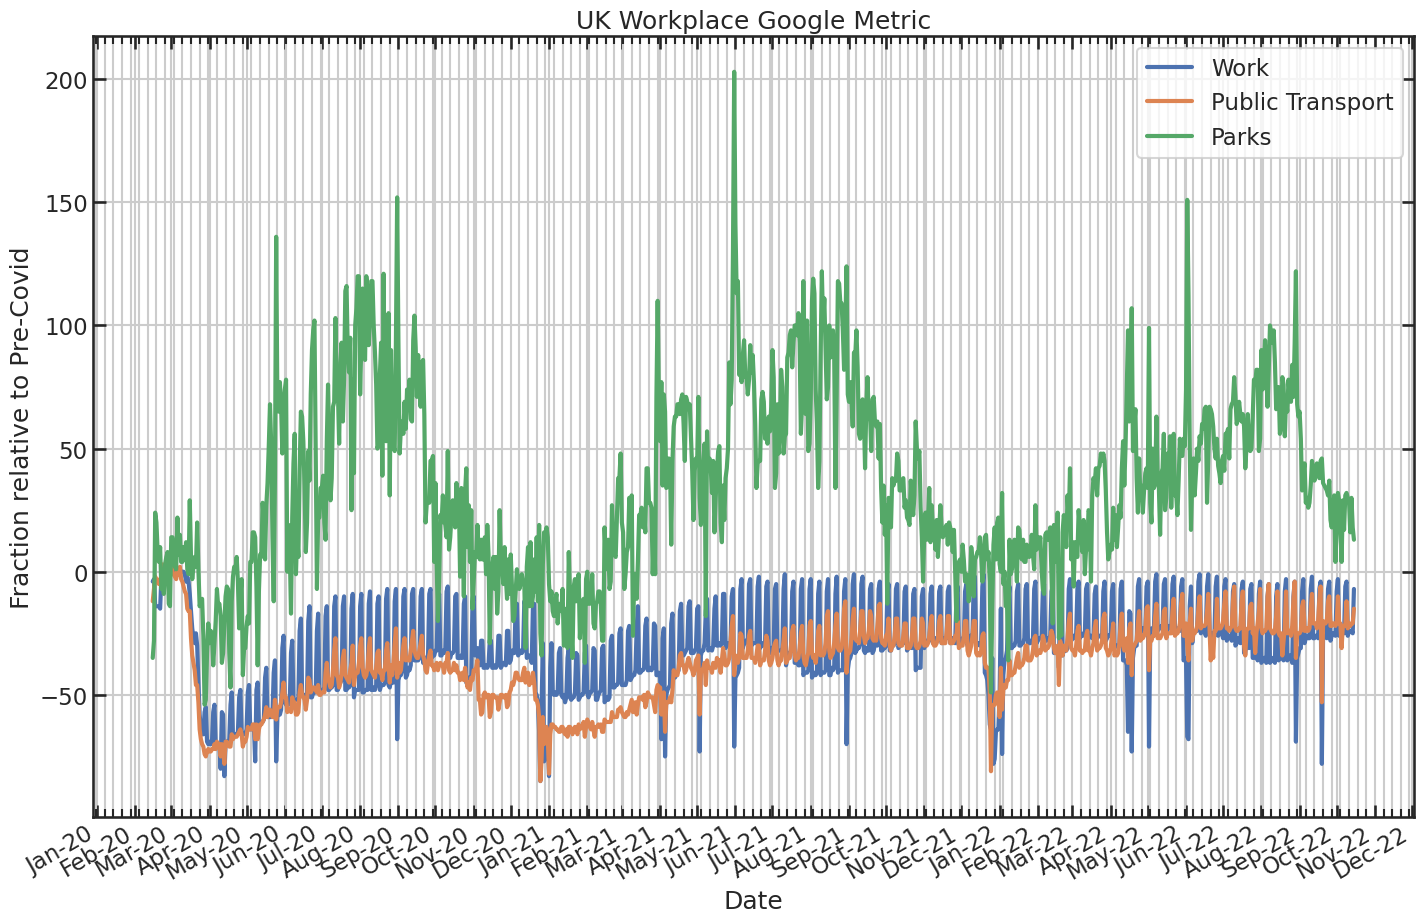

In [7]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

## The UK data from the covid period.

The UK data is available as a zip file from:

https://ukhsa-dashboard.data.gov.uk/covid-19-archive-data-download

this then needs to be unzipped 
```console
unzip  covid-19-archive.zip
```
This should produce a series of directories:
```console
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Cases
-rw-r--r--. 1 collngdj collngdj 1592889236 Oct 25 16:07 covid-19-archive.zip
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Deaths
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Healthcare
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Testing
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Vaccinations
```

each of these has a set of csv files arranged over different years.

The following code is an example of how you might want to read these in and concatinate them over different years.



In [8]:
import re
from enum import StrEnum, auto
import pathlib
import pandas as pd

class DataType(StrEnum):
    Cases = auto()
    Deaths = auto()
    Healthcare = auto()
    Testing = auto()
    Vaccinations = auto()


def csvconcat(datatype: DataType,
              metric: str | None = None,
              dataroot: str | pathlib.Path = pathlib.Path.cwd()) -> dict[str, pd.DataFrame]:
    """
    Get Pandas DataFrames from the UK COVID-19 .csv data, Concatenated across years.

    Args:
        datatype (DataType): Corresponds to the directory to scan use enum type above.
                             i.e. [DataType.Cases|DataType.Deaths|DataType.Healthcare|
                                   DataType.Testing|DataType.Vaccinations]
        metric (str | None, optional): Chose an individual metric to process. If None (the default) then all
                                       metrics for the given DataType are processed. Defaults to None.
        dataroot (pathlib.Path, optional): The root directory for the unpacked UK COVID-19 data.
                                           DataType directories (Cases/Deaths) etc should be under this root.
                                           Defaults to pathlib.Path.cwd().
    Raises:
        ValueError: If there is a failure to convert the given dataroot to a Path object.

    Returns:
        dict[str, pd.DataFrame]: The mapping from metric to fully concatenated DataFrame.
    """
    if not isinstance(dataroot, pathlib.Path):
        try:
            dataroot = pathlib.Path(dataroot)
        except:
            raise ValueError(f"dataroot: '{dataroot}' could not be converted to a Path.")

    dataroot /= datatype.name
    # metric_regex = re.compile(r"(?P<metric>\w+?)_(?P<specifier>nation|region|utla|ltla|overview)_20\d\d.csv")
    metric_regex = re.compile(r"(?P<specifier>nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>\w+?).csv")
    metrics: set[str] = {str(metric)}
    if metric is None:
        file_list = (file_.relative_to(dataroot).name for file_ in dataroot.rglob("*.csv"))
        metrics = {match.group("metric") for file_ in file_list if (match := metric_regex.match(file_))}

    ret = {}
    for current_metric in metrics:
        ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"*_{current_metric}.csv"))})
        # ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"{current_metric}_*.csv"))})

    return ret



In [13]:
# Get a specific metric
from pathlib import Path
# data = csvconcat(DataType.Healthcare, "hospitalCases")
data = csvconcat(DataType.Healthcare, "hospitalCases", dataroot=Path.cwd() / "UK data") # I changed mine to this b/c of the path to my data, you may need to change depending on where your data is.
print(data)

{'hospitalCases':             date area_type  area_code         area_name         metric  \
0     2020-03-27  overview  K02000001    United Kingdom  hospitalCases   
1     2020-03-28  overview  K02000001    United Kingdom  hospitalCases   
2     2020-03-29  overview  K02000001    United Kingdom  hospitalCases   
3     2020-03-30  overview  K02000001    United Kingdom  hospitalCases   
4     2020-03-31  overview  K02000001    United Kingdom  hospitalCases   
...          ...       ...        ...               ...            ...   
5227  2023-12-08    nation  E92000001           England  hospitalCases   
5228  2023-12-08    nation  N92000002  Northern Ireland  hospitalCases   
5229  2023-12-09    nation  N92000002  Northern Ireland  hospitalCases   
5230  2023-12-10    nation  N92000002  Northern Ireland  hospitalCases   
5231  2023-12-11    nation  N92000002  Northern Ireland  hospitalCases   

               metric_name    value  
0     Patients in hospital   7267.0  
1     Patients in

In [14]:
# List metrics present by filename so i can easily choose what i want
from pathlib import Path
import re

def list_metrics_in_folder(folder: Path):
    rx = re.compile(r"^(?:nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>[\w]+?)(?:_20\d\d)?\.csv$")
    return sorted({m.group("metric") for f in folder.glob("*.csv") if (m := rx.match(f.name))})

healthcare_dir = Path.cwd() / "UK data" / "Healthcare"
all_directory_metrics = [Path.cwd() / "UK data" / "Cases", Path.cwd() / "UK data" / "Deaths", Path.cwd() / "UK data" / "Healthcare", Path.cwd() / "UK data" / "Testing", Path.cwd() / "UK data" / "Vaccinations"]
for path in all_directory_metrics:
    print(f"{path.name} metrics: {list_metrics_in_folder(path)}")

Cases metrics: ['changeInCumCasesBySpecimenDate', 'changeInNewCasesBySpecimenDate', 'cumCasesByPublishDate', 'cumCasesByPublishDateRate', 'cumCasesBySpecimenDate', 'cumCasesBySpecimenDateRate', 'cumCasesLFDConfirmedPCRBySpecimenDate', 'cumCasesLFDOnlyBySpecimenDate', 'cumCasesPCROnlyBySpecimenDate', 'cumCasesPillarOneBySpecimenDate', 'cumCasesPillarOneBySpecimenDateRate', 'cumCasesPillarTwoBySpecimenDate', 'cumFirstEpisodesBySpecimenDate', 'cumFirstEpisodesBySpecimenDateRate', 'cumReinfectionsBySpecimenDate', 'cumReinfectionsBySpecimenDateRate', 'femaleCases', 'hospitalCasesWeekly', 'maleCases', 'newCasesByPublishDate', 'newCasesByPublishDateChange', 'newCasesByPublishDateChangePercentage', 'newCasesByPublishDateDirection', 'newCasesByPublishDateRollingRate', 'newCasesByPublishDateRollingSum', 'newCasesBySpecimenDate', 'newCasesBySpecimenDateAgeDemographics', 'newCasesBySpecimenDateAgeDemographics_areas_letter_A', 'newCasesBySpecimenDateAgeDemographics_areas_letter_B', 'newCasesBySpeci

In [16]:
# Get all metrics for a DataType
data = csvconcat(DataType.Healthcare, dataroot=Path.cwd() / "UK data")
print(f"Data contains {len(data)} concatenated metrics")
print(f"Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: {'transmissionRateGrowthRateMax' in data}")
print("Available metrics:")
print(list(data.keys()))

Data contains 50 concatenated metrics
Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: True
Available metrics:
['suspectedCovidOccupiedMVBeds', 'newAdmissions', 'transmissionRateMax', 'totalMVBeds', 'cumAdmissionsRate', 'covidOccupiedMVBeds', 'newAdmissionsByAge', 'suspectedCovidOccupiedNIVBeds', 'covidOccupiedOtherBeds', 'totalOSBeds', 'totalOtherBeds', 'newAdmissionsRollingSum', 'covidOccupiedMVBedsWeekly', 'newDischarges', 'newAdmissionsRollingRate', 'transmissionRateGrowthRateMin', 'totalBeds', 'cumDischarges', 'cumDischargesByAge', 'transmissionRateGrowthRateMax', 'hospitalCases_archive', 'totalNIVBeds', 'cumCasesPillarTwoBySpecimenDateRate', 'nonCovidOccupiedNIVBeds', 'cumDischargesRate', 'unoccupiedMVBeds', 'newAdmissionsWeekly_archive', 'nonCovidOccupiedOtherBeds', 'unoccupiedOtherBeds', 'previouslyReportedCumCasesBySpecimenDate', 'newAdmissionsChangePercentage', 'nonCovidOccupiedOSBeds', 'covidOccupiedNIVBeds', 'newAdmissionsWeekly', 'cumAdmissionsB

 The first thing that you might want to play around with is trying to plot some of these data and comparing them to the different predictors.